<a href="https://colab.research.google.com/github/EventHopper/ReviewsScraping/blob/master/FBL_App_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FB Local Competitive Review**


---


### **Application**
**Facebook Local**

Details:

Size: 200 MB+,
Installs: 5M+,
Requires Android 4.1+

---



### **Review Rationale**

*We want to review feedback for this app on the Google Play Store and AppStore. Note that both negative and positive are good, however the negative reviews can reveal critical features that are missing or significant bugs (if they appear frequently).*
<br>

### **Packages Used**

**Google Play Store Related Packages:**

 - [google-play-scraper](https://github.com/JoMingyu/google-play-scraper)

**AppStore Related Packages:**

- [app-store](https://github.com/rrueth/app-store)

# Project Init

In [1]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 51kB 1.9MB/s 


In [0]:
!pip install -qq -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

CPython 3.6.9
IPython 5.5.0

pandas 1.0.4
matplotlib 3.2.1
seaborn 0.10.1
google_play_scraper 0.0.2.6


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%%capture
!pip install pandasql
!pip install chart-studio
!pip install sqlalchemy
!pip install sqlite3
!pip install scikit-plot

In [0]:
import json
import time
import pandas as pd
from tqdm import tqdm
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandasql import sqldf

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
# plt.style.use('v2.0')
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Data Wrangling

## Google Play Store Scraping

Step Summary:

- Scrape Google Play app information
- Scrape user reviews for Google Play apps
- Save the dataset to CSV files

Package name of app: com.facebook.Socal
Obtained using ADB shell command


```
$ adb shell "pm list packages -f facebook"
```

In [0]:
app_packages = [
  'com.facebook.Socal'
]

Utilized package name in for loop (note multiple package names could have been added to app_packages for same result)

In [8]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


We got the info for the app. Let's write a helper function that prints JSON objects a bit better:

In [0]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [10]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "4.1",
  "androidVersionText": "4.1 and up",
  "appId": "com.facebook.Socal",
  "containsAds": null,
  "contentRating": "Teen",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Welcome to Facebook Local!\u00a0We\u2019ve updated our events app to help you discover places and things to do recommended by friends you know and trust.\r\n\r\nKeep up with what\u2019s happening locally\u2014wherever you are\u2014whether you\u2019re looking for something to do with friends this weekend or want to explore a new neighborhood.\r\n\r\nFeatures:\r\n\r\n* See the most recent activity, events and places your friends are interacting with and updates from event hosts and Pages you follow.\r\n* Find events and activities happening near you on an interactive map and filter by time, category, location and more.\r\n* Get recommendations based on what's popular with your friends, things you've been to in the past, Pages you like and our c

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). Let's ignore all of that and have a look at their beautiful icons:

In [11]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

<Figure size 1008x360 with 0 Axes>

In [0]:
timestr = time.strftime("%Y%m%d-%H%M%S")
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('app_details'+timestr+'_ANDROID.csv', index=None, header=True)

### Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

In [0]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


In [0]:
print_json(app_reviews[0])

{
  "appId": "com.facebook.Socal",
  "at": "2020-04-22 11:54:28",
  "content": "Uses 496MB internal memory and won't run from SD. Poor quality assurance - some businesses appear randomly dropped in entirely the wrong place (e.g. Costa, Manchester Arndale Centre is shown on a housing estate near Bolton). Uninstalled.",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "19.0.0.52.2104",
  "reviewId": "gp:AOqpTOGGWG0mw15Cg7v0CXrB2FRJ5vToBK6ndfUuDGDfyPdmc5r6ya5g6pCI7SimADOzWuExJ7aR01WemP-g_zQ",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 305,
  "userImage": "https://lh3.googleusercontent.com/-62mHJxvVL2o/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucnrlZzdPDn2zp6QN_DRqhkPnsFupg/photo.jpg",
  "userName": "Tom Higgs"
}



In [0]:
len(app_reviews)

1122

In [0]:
timestr = time.strftime("%Y%m%d-%H%M%S")
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('FacebookLocalReviews_ANDROID-'+timestr+'.csv', index=None, header=True)

## AppStore Scraping

In [0]:
!pip install app_store

In [0]:
import app_store.reviews
import pandas as pd

In [0]:
d = []
i = 1;
try:
  while(True):
    reviews = app_store.reviews.fetch_reviews(app_id=1153443320, page_num=i)
    for review in reviews:
      d.append((review.title(), review.rating(), review.author_name(), review.version(), review.content()))
    i+=1
except:
  print("Page number not found ", i)

ios_reviews_df = pd.DataFrame(d, columns=('Review_Title', 'Rating', 'Author_Name', 'Review_Version', 'Content'))

Page number not found  8


In [0]:
timestr = time.strftime("%Y%m%d-%H%M%S")
ios_reviews_df.to_csv('FacebookLocalReviews_IOS-'+timestr+'.csv', index=None, header=True)
ios_reviews_df.head(10)

,Review_Title,Rating,Author_Name,Review_Version,Content
0,Local by Facebook,2,Litlecamper,32.0,I’m not very tech savvy but I noticed this sit...
1,Notifications screen doesn’t load,1,Daguerratype,32.0,"Latest update broke the notification screen, m..."
2,Trying to post an event,1,Snode3,32.0,Invalid request domain: Blah blah blah. How...
3,App crashes,1,ariesanna,31.0,App opens and crashes when try to change inter...
4,please let us block/hide events,1,smoniaa,31.0,please please create the option to block or hi...
5,Please give us dark mode and an iPad version!,2,Sicilianvirgo,31.0,iPad version would allow us to use it in lands...
6,What happened here?,2,Lawrence Kay,31.0,The app is so busy promoting “other” events th...
7,No calendar sync? Seriously?,1,100%Insomniac,31.0,"This app, and Facebook events in general, coul..."
8,"Hard to use, weird sorting",1,BahnBahn,31.0,The sorting makes this app really hard to use....
9,Handy but needs an update!,2,laurenrodgers90,30.0,I create events quite often. But recently for ...




---

# EDA

Next, we're going to use the reviews for an Exploratory Data Analysis


---




#### CSV Import
**android_reviews_df**

In [0]:
git_url_android = "https://raw.githubusercontent.com/EventHopper/Research/master/Raw%20Data/Reviews/FacebookLocalReviews_ANDROID-20200610-155835.csv?token=AF24RR4PQXNPM6CMDMYPPUS65I7C2"
android_reviews_df = pd.read_csv(git_url_android)


# Cleaning
android_reviews_df = android_reviews_df.drop(columns=['reviewId', 'appId', 'userImage', 'sortOrder'])
android_reviews_df.rename(columns={'at': 'time'}, inplace=True)
android_reviews_df['time'] = android_reviews_df['time'].apply(lambda x : pd.to_datetime(x))
android_reviews_df['date'] = android_reviews_df['time'].dt.strftime('%Y-%m')

In [14]:
android_reviews_df.dtypes

userName                        object
content                         object
score                            int64
thumbsUpCount                    int64
reviewCreatedVersion            object
time                    datetime64[ns]
replyContent                   float64
repliedAt                      float64
date                            object
dtype: object

In [0]:
android_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date
0,Tom Higgs,Uses 496MB internal memory and won't run from ...,1,284,19.0.0.52.2104,2020-04-22 11:54:28,NaN,NaN,2020-04
1,Big Bang Bojo,"Third class apps.While i open this apps,it wor...",1,2,19.0.0.52.2104,2020-06-02 10:19:45,NaN,NaN,2020-06
2,Krypton Stratos,Abandoned this app for Eventbrite when the opt...,1,20,NaN,2020-04-27 08:41:02,NaN,NaN,2020-04
3,A Google user,"I love the app and the concept is great, but p...",1,116,18.0.0.46.1099,2020-03-15 01:16:49,NaN,NaN,2020-03
4,Harley McCain,The concept of the app is great! I would give ...,1,795,18.0.0.46.1099,2020-02-23 15:23:48,NaN,NaN,2020-02


In [0]:
android_reviews_df.describe()

,score,thumbsUpCount,replyContent,repliedAt
count,1122.00000,1122.000000,0.0,0.0
mean,3.00000,35.816399,NaN,NaN
std,1.33571,129.210276,NaN,NaN
min,1.00000,0.000000,NaN,NaN
25%,2.00000,1.000000,NaN,NaN
50%,3.00000,4.000000,NaN,NaN
75%,4.00000,17.000000,NaN,NaN
max,5.00000,1892.000000,NaN,NaN


#### iOS CSV Import
**ios_reviews_df**

In [0]:
git_url_ios = "https://raw.githubusercontent.com/EventHopper/Research/master/Raw%20Data/Reviews/FacebookLocalReviews_IOS-20200610-155754.csv?token=AF24RR2ULS2ZZJJH5M64QFS65I7EO"
ios_reviews_df = pd.read_csv(git_url_ios)

In [22]:
# Cleaning

ios_reviews_df.head()

,Review_Title,Rating,Author_Name,Review_Version,Content
0,Notifications screen doesn’t load,1,Daguerratype,32.0,"Latest update broke the notification screen, m..."
1,Trying to post an event,1,Snode3,32.0,Invalid request domain: Blah blah blah. How...
2,App crashes,1,ariesanna,31.0,App opens and crashes when try to change inter...
3,please let us block/hide events,1,smoniaa,31.0,please please create the option to block or hi...
4,Please give us dark mode and an iPad version!,2,Sicilianvirgo,31.0,iPad version would allow us to use it in lands...


In [23]:
ios_reviews_df.dtypes

Review_Title       object
Rating              int64
Author_Name        object
Review_Version    float64
Content            object
dtype: object

#### Basic Insights

In [0]:
opinions_df = lambda q: sqldf(q, globals())
query = """
SELECT
    AVG(p.score) as average_score, p.date as date
FROM
    android_reviews_df p
GROUP BY
    p.Date
ORDER BY
    p.Date ASC
"""
df_temp = opinions_df(query)
df_temp.head()
android_grouped_by_score_df = df_temp
android_grouped_by_score_df.head()

,average_score,date
0,3.0,2016-12
1,3.0,2017-03
2,3.0,2017-04
3,3.0,2017-07
4,3.0,2017-08


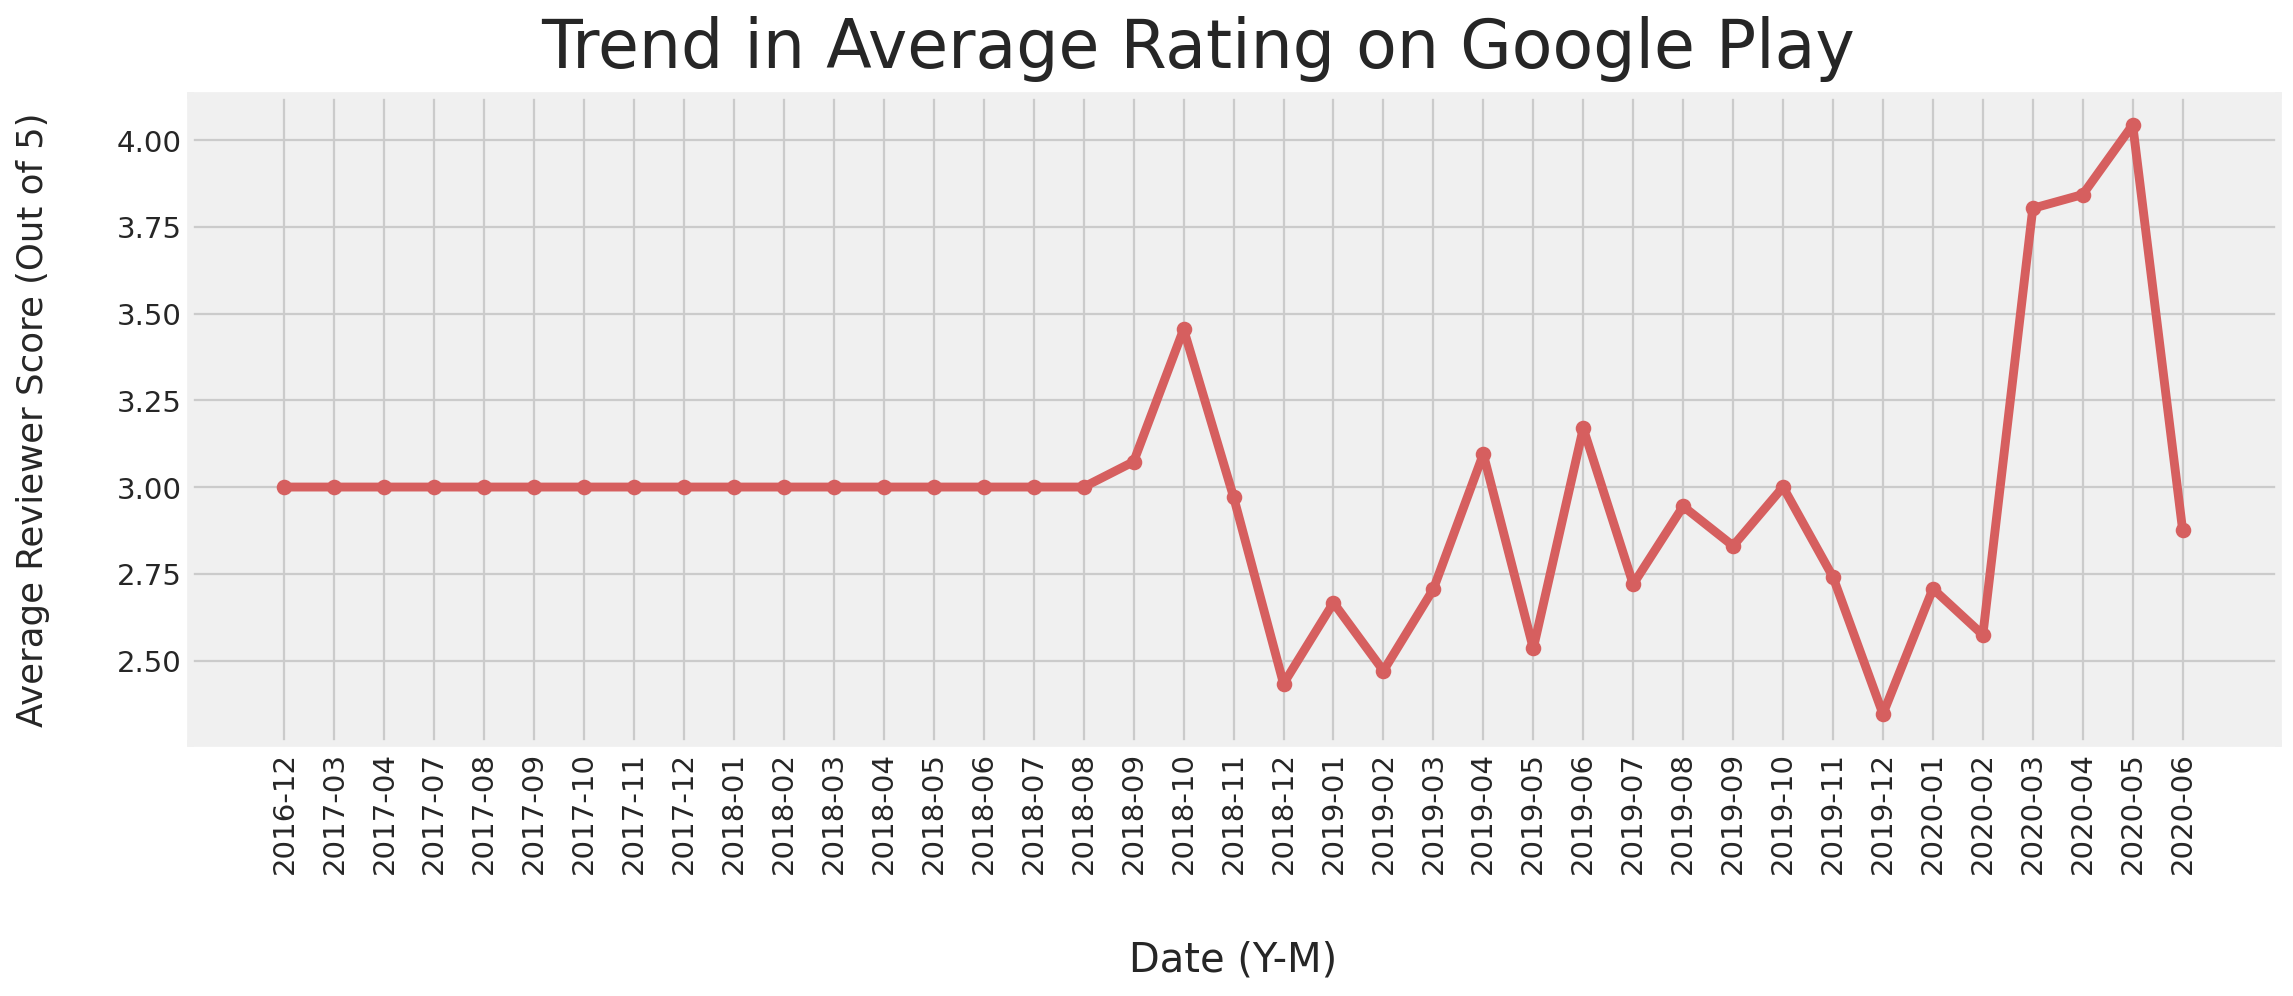

In [0]:
labelpad = 30
    
with plt.style.context('fivethirtyeight'):
    fig = figure(num=None, figsize=(15,5), dpi=80, facecolor='white', edgecolor='w')
    fig.suptitle('Trend in Average Rating on Google Play', fontsize=30)
    plt.xlabel('Date (Y-M)', fontsize=18, labelpad=labelpad)
    plt.ylabel('Average Reviewer Score (Out of 5)', fontsize=16, labelpad=labelpad)
    plt.plot(android_grouped_by_score_df.date, android_grouped_by_score_df.average_score, 'r-o')
    plt.xticks(rotation='vertical',ticks = None, labels=None)
plt.show()

#### Sentiment Analysis

In [0]:
from textblob import TextBlob

**Polarity Metric** - from -1 to 1 a metric of how positive or negative a review is 

**Subjectivity Metric** - measured between 0 and 1 based on factual information vs generic opinion

[See Here for Learning about TextBlob](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/#:~:text=The%20sentiment%20function%20of%20textblob,properties%2C%20polarity%2C%20and%20subjectivity.&text=Subjective%20sentences%20generally%20refer%20to,of%20%5B0%2C1%5D.)

[TextBlob uses a Naive Bayes algorithm as a part of Stanford's NLTK and was trained on movie reviews to determine textual sentiment](https://stackoverflow.com/questions/34518570/how-are-sentiment-analysis-computed-in-blob)

In [0]:
# Word Count 
android_reviews_df['word_count'] = android_reviews_df['content'].apply(lambda x: len(x.split()))
android_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count
0,Tom Higgs,Uses 496MB internal memory and won't run from ...,1,284,19.0.0.52.2104,2020-04-22 11:54:28,NaN,NaN,2020-04,37
1,Big Bang Bojo,"Third class apps.While i open this apps,it wor...",1,2,19.0.0.52.2104,2020-06-02 10:19:45,NaN,NaN,2020-06,34
2,Krypton Stratos,Abandoned this app for Eventbrite when the opt...,1,20,NaN,2020-04-27 08:41:02,NaN,NaN,2020-04,77
3,A Google user,"I love the app and the concept is great, but p...",1,116,18.0.0.46.1099,2020-03-15 01:16:49,NaN,NaN,2020-03,40
4,Harley McCain,The concept of the app is great! I would give ...,1,795,18.0.0.46.1099,2020-02-23 15:23:48,NaN,NaN,2020-02,70


In [25]:
ios_reviews_df['word_count'] = ios_reviews_df['Content'].apply(lambda x: len(x.split()))
ios_reviews_df.head()

,Review_Title,Rating,Author_Name,Review_Version,Content,word_count
0,Notifications screen doesn’t load,1,Daguerratype,32.0,"Latest update broke the notification screen, m...",10
1,Trying to post an event,1,Snode3,32.0,Invalid request domain: Blah blah blah. How...,17
2,App crashes,1,ariesanna,31.0,App opens and crashes when try to change inter...,13
3,please let us block/hide events,1,smoniaa,31.0,please please create the option to block or hi...,11
4,Please give us dark mode and an iPad version!,2,Sicilianvirgo,31.0,iPad version would allow us to use it in lands...,25


In [0]:
#Number of characters
android_reviews_df['char_count']=android_reviews_df['content'].apply(lambda x: len(x))
android_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count
0,Tom Higgs,Uses 496MB internal memory and won't run from ...,1,284,19.0.0.52.2104,2020-04-22 11:54:28,NaN,NaN,2020-04,37,237
1,Big Bang Bojo,"Third class apps.While i open this apps,it wor...",1,2,19.0.0.52.2104,2020-06-02 10:19:45,NaN,NaN,2020-06,34,194
2,Krypton Stratos,Abandoned this app for Eventbrite when the opt...,1,20,NaN,2020-04-27 08:41:02,NaN,NaN,2020-04,77,497
3,A Google user,"I love the app and the concept is great, but p...",1,116,18.0.0.46.1099,2020-03-15 01:16:49,NaN,NaN,2020-03,40,237
4,Harley McCain,The concept of the app is great! I would give ...,1,795,18.0.0.46.1099,2020-02-23 15:23:48,NaN,NaN,2020-02,70,365


In [26]:
ios_reviews_df['char_count'] = ios_reviews_df['Content'].apply(lambda x: len(x))
ios_reviews_df.head()

,Review_Title,Rating,Author_Name,Review_Version,Content,word_count,char_count
0,Notifications screen doesn’t load,1,Daguerratype,32.0,"Latest update broke the notification screen, m...",10,68
1,Trying to post an event,1,Snode3,32.0,Invalid request domain: Blah blah blah. How...,17,94
2,App crashes,1,ariesanna,31.0,App opens and crashes when try to change inter...,13,77
3,please let us block/hide events,1,smoniaa,31.0,please please create the option to block or hi...,11,65
4,Please give us dark mode and an iPad version!,2,Sicilianvirgo,31.0,iPad version would allow us to use it in lands...,25,128


In [0]:
def average_words(x):
  words = x.split()
  return sum(len(word) for word in words)/len(words)

In [28]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stop_words = stopwords.words('english')

In [0]:
android_reviews_df['average_word_length'] = android_reviews_df['content'].apply(lambda x: average_words(x))
android_reviews_df['stopword_count'] = android_reviews_df['content'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
android_reviews_df['lowercase'] = android_reviews_df['content'].apply(lambda x: " ".join(word.lower() for word in x.split()))
android_reviews_df['punctuation'] = android_reviews_df['lowercase'].str.replace('[^\w\s]',' ')
android_reviews_df['stopwords']  = android_reviews_df['punctuation'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

In [0]:
ios_reviews_df['average_word_length'] = ios_reviews_df['Content'].apply(lambda x: average_words(x))
ios_reviews_df['stopword_count'] = ios_reviews_df['Content'].apply(lambda x : len([word for word in x.split() if word.lower() in stop_words]))
ios_reviews_df['lowercase'] = ios_reviews_df['Content'].apply(lambda x: " ".join(word.lower() for word in x.split()))
ios_reviews_df['punctuation'] = ios_reviews_df['lowercase'].str.replace('[^\w\s]',' ')
ios_reviews_df['stopwords'] = ios_reviews_df['punctuation'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

In [0]:
#Did this to see the most frequently occuring words that weren't in nltk
pd.Series(" ".join(android_reviews_df['stopwords']).split()).value_counts()[:30]

app              600
events           359
facebook         225
great            164
event            137
good             131
like             116
would            108
use              107
work              92
time              92
local             88
see               88
really            79
get               72
open              67
find              67
notifications     66
fb                65
calendar          60
nice              59
love              57
one               56
search            56
even              56
going             55
want              53
please            50
way               49
new               48
dtype: int64

In [31]:
pd.Series(" ".join(ios_reviews_df['stopwords']).split()).value_counts()[:30]

app              357
events           239
facebook         121
event             78
calendar          77
see               74
notifications     66
like              57
fb                54
update            53
find              50
would             48
use               47
local             43
want              43
going             43
get               39
please            39
one               39
new               37
great             36
time              36
way               36
love              36
friends           35
page              35
search            33
go                31
open              30
useful            29
dtype: int64

In [0]:
# Manual Removing of words
other_stop_words = ['app', 'events', 'facebook', 'see', 'fb', 'im', 'really']
android_reviews_df['cleanreview'] = android_reviews_df['stopwords'].apply(lambda x: " ".join(word for word in x.split() if word not in other_stop_words)) 
ios_reviews_df['cleanreview'] = ios_reviews_df['stopwords'].apply(lambda x: " ".join(word for word in x.split() if word not in other_stop_words)) 

Lemmatization

In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
import textblob
from textblob import Word

In [0]:
android_reviews_df['lemmatized'] = android_reviews_df['cleanreview'].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))
ios_reviews_df['lemmatized'] = ios_reviews_df['cleanreview'].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))

In [0]:
android_reviews_df['polarity'] = android_reviews_df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[0])
android_reviews_df['subjectivity'] = android_reviews_df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[1])


ios_reviews_df['polarity'] = ios_reviews_df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[0])
ios_reviews_df['subjectivity'] = ios_reviews_df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[1])

In [0]:
android_reviews_df.describe()

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,1122.00000,1122.000000,0.0,0.0,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000
mean,3.00000,35.816399,NaN,NaN,21.311943,114.074866,4.535140,9.608734,0.191650,0.414123
std,1.33571,129.210276,NaN,NaN,22.602661,121.984021,1.408720,11.084512,0.310378,0.299078
min,1.00000,0.000000,NaN,NaN,1.000000,2.000000,1.500000,0.000000,-0.800000,0.000000
25%,2.00000,1.000000,NaN,NaN,4.000000,24.000000,4.000000,1.000000,0.000000,0.100000
50%,3.00000,4.000000,NaN,NaN,13.000000,66.500000,4.333333,5.000000,0.114394,0.466667
75%,4.00000,17.000000,NaN,NaN,30.000000,167.750000,4.809066,14.000000,0.400000,0.600000
max,5.00000,1892.000000,NaN,NaN,123.000000,724.000000,20.562500,56.000000,1.000000,1.000000


#### Sentiment Analysis Result - (Better Searchable Data)

**TODO: Convert all of the code above into a simple function or package for subsequent review CSVs**

In [0]:
android_reviews_df.sort_values(by=['polarity', 'thumbsUpCount'], ascending=[True, True])

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
157,Bike Tracker Car Engine Blocker Techniques,"Very stupid application wasting time only, thi...",1,4,18.0.0.46.1099,2020-01-11 14:25:21,NaN,NaN,2020-01,15,104,6.000000,5,"very stupid application wasting time only, thi...",very stupid application wasting time only thi...,stupid application wasting time reason uninsta...,stupid application wasting time reason uninsta...,stupid application wasting time reason uninsta...,-0.8,1.000000
30,Alexandra Zaharia,This app is the worst. The search does not wor...,1,505,18.0.0.46.1099,2019-12-08 20:02:22,NaN,NaN,2019-12,85,442,4.211765,46,this app is the worst. the search does not wor...,this app is the worst the search does not wor...,app worst search work together filters makes u...,worst search work together filters makes usele...,worst search work together filter make useless...,-0.7,0.680000
177,Alexandra Zaharia,This app is the worst. The search does not wor...,1,505,18.0.0.46.1099,2019-12-08 20:02:22,NaN,NaN,2019-12,85,442,4.211765,46,this app is the worst. the search does not wor...,this app is the worst the search does not wor...,app worst search work together filters makes u...,worst search work together filters makes usele...,worst search work together filter make useless...,-0.7,0.680000
107,Footage Entertainment,Very bad,1,0,NaN,2020-04-29 01:45:11,NaN,NaN,2020-04,2,8,3.500000,1,very bad,very bad,bad,bad,bad,-0.7,0.666667
167,m56 mz,Bad,1,1,18.0.0.46.1099,2019-12-23 23:55:26,NaN,NaN,2019-12,1,3,3.000000,0,bad,bad,bad,bad,bad,-0.7,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,michele matteo,Wonderful!!,5,1,18.0.0.46.1099,2020-03-10 16:08:22,NaN,NaN,2020-03,1,11,11.000000,0,wonderful!!,wonderful,wonderful,wonderful,wonderful,1.0,1.000000
1094,Nikko Soria,Awesome app,5,2,18.0.0.46.1099,2020-03-22 09:58:48,NaN,NaN,2020-03,2,11,5.000000,0,awesome app,awesome app,awesome app,awesome,awesome,1.0,1.000000
993,Louisa Jaskulski,It is wonderful.to have a way to.learn about m...,5,3,14.0,2019-06-11 14:48:42,NaN,NaN,2019-06,17,84,4.000000,11,it is wonderful.to have a way to.learn about m...,it is wonderful to have a way to learn about m...,wonderful way learn going around,wonderful way learn going around,wonderful way learn going around,1.0,1.000000
1038,sayedcoolingsolution In thane,Awesome,5,3,19.0.0.52.2104,2020-05-15 15:18:32,NaN,NaN,2020-05,1,7,7.000000,0,awesome,awesome,awesome,awesome,awesome,1.0,1.000000


In [42]:
ios_reviews_df.sort_values(by=['polarity'], ascending=[True])

,Review_Title,Rating,Author_Name,Review_Version,Content,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
15,Gross,1,clacky312,28.0,Nasty communists,2,16,7.500000,0,nasty communists,nasty communists,nasty communists,nasty communists,nasty communist,-1.000,1.00
199,Incorrect Information horrible app,1,MichaelDevaney,9.0,Don’t bother it has all wrong information - in...,27,177,5.592593,7,don’t bother it has all wrong information - in...,don t bother it has all wrong information in...,bother wrong information incorrect ratings pho...,bother wrong information incorrect ratings pho...,bother wrong information incorrect rating phot...,-0.750,0.95
97,Hate this app soooo much!,1,You wont let me pick a name,15.1,This app is the worst! If it gets the wrong in...,64,337,4.281250,33,this app is the worst! if it gets the wrong in...,this app is the worst if it gets the wrong in...,app worst gets wrong information move shop scr...,worst gets wrong information move shop screwed...,worst get wrong information move shop screwed ...,-0.625,0.75
100,Organization Disaster with No Calendar Integra...,2,TaylorElizabeth26,15.1,Opening this app gives me anxiety in terms of ...,25,146,4.880000,11,opening this app gives me anxiety in terms of ...,opening this app gives me anxiety in terms of ...,opening app gives anxiety terms design difficu...,opening gives anxiety terms design difficult f...,opening give anxiety term design difficult fin...,-0.500,1.00
46,Watch out for fake events,1,Sarageddon,22.0,"Just like there are fake news in Facebook, the...",15,80,4.400000,8,"just like there are fake news in facebook, the...",just like there are fake news in facebook the...,like fake news facebook fake events charge,like fake news fake charge,like fake news fake charge,-0.500,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Informative but has glitches,3,Texamanian,26.0,I get my notifications and other suggestions i...,30,168,4.600000,14,i get my notifications and other suggestions i...,i get my notifications and other suggestions i...,get notifications suggestions area nearby area...,get notifications suggestions area nearby area...,get notification suggestion area nearby area a...,1.000,1.00
308,Awesome!,5,MComi,1.0,Just awesome,2,12,5.500000,1,just awesome,just awesome,awesome,awesome,awesome,1.000,1.00
253,Great,5,JThomson453,5.0,The map feature is awesome,5,26,4.400000,2,the map feature is awesome,the map feature is awesome,map feature awesome,map feature awesome,map feature awesome,1.000,1.00
102,Facebooks best app,5,SoumiaF,15.1,For me facebooks forte is in connecting me to ...,20,98,3.950000,11,for me facebooks forte is in connecting me to ...,for me facebooks forte is in connecting me to ...,facebooks forte connecting people offline even...,facebooks forte connecting people offline best...,facebooks forte connecting people offline best...,1.000,0.30


### **Read A Review**

To read a **review** at a specific index edit the **review_id** in the  code block below

**Reviews of interest (ids)**

UX Problems: 230, 235, 436, 260, 269, 271 (haha), 503

Family Filter: 500, 502

Calendar: 246

Cluttering: 419, 270, 26, 504

Facebook's Approach: 221, 225, 227, 198

In [20]:
#Edit review_id to read a full review
review_id = 221

#______________________________________________________________________________#
#Format:
#[Date]
#[Score out of 5]
#[Thumbs Up Count]
#Review
import textwrap
msg = textwrap.dedent('['+android_reviews_df.iloc[review_id,:].date + ']'
      + '\n[Score: '+android_reviews_df.iloc[review_id,:].score.astype(str) + ']' 
      + '\n[UpVotes: '+android_reviews_df.iloc[review_id,:].thumbsUpCount.astype(str) + '] \n' 
      + android_reviews_df.iloc[review_id,:].content)
print ('\n'.join(l for line in msg.splitlines() 
                  for l in textwrap.wrap(line, width=130)))
#______________________________________________________________________________#

[2019-09]
[Score: 2]
[UpVotes: 244]
I wanted this so i could remove FB & just keep events, but it's not really functional. No notifications, so I'm not seeing things
that I'm invited to unless they're coming up soon; no notifications within events I'm already going to; no notifications from
events I'm hosting.to check for notifications or updates i have to open the event through Facebook which seems to defeat the
purpose. Also no way of hiding events that I'm invited to but am not interested in.


#### Data Frame Splitting

In [0]:
# Dataframe Splitting

#Reviews between x and y
good = android_reviews_df['score'].between(4, 5, inclusive=True)
average = android_reviews_df['score'].between(2, 4, inclusive=False)
poor = android_reviews_df['score'].between(1, 2, inclusive=True)

android_good_df = android_reviews_df[good]
android_average_df = android_reviews_df[average]
android_poor_df = android_reviews_df[poor]

#Pain Point Discovery

### Hypotheses
For Users:
- Cluttered atmosphere of Facebook events (Events get drowned out including invites)
- Facebook Local doesn't sync with calendar well

For Event Planners:
- Apathy towards events (spamming the interested button)
- A good single source for upcoming events

### **Calendar Syncing**

In [0]:
targets = ['calendar', 'sync', 'schedule', 'scheduling', 'week', 'month', 'year']
calendar_reviews_df = android_reviews_df[android_reviews_df.content.apply(lambda sentence: any(word in sentence for word in targets))]
calendar_reviews_df.describe()
#46 Reviews mentioning calendar-related content. 
#Average polarity is 0.05 (near neutral, marginally positive). Average objectivity

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,101.000000,101.000000,0.0,0.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,2.504950,82.217822,NaN,NaN,45.960396,245.386139,4.338243,21.306931,0.096406,0.436165
std,1.261933,209.986885,NaN,NaN,28.703979,156.017561,0.373845,14.053286,0.246953,0.244923
min,1.000000,0.000000,NaN,NaN,8.000000,36.000000,3.612903,3.000000,-0.460000,0.000000
25%,1.000000,7.000000,NaN,NaN,21.000000,121.000000,4.078431,10.000000,-0.029167,0.306944
50%,3.000000,13.000000,NaN,NaN,39.000000,204.000000,4.366667,18.000000,0.050000,0.445833
75%,3.000000,66.000000,NaN,NaN,68.000000,335.000000,4.560000,34.000000,0.250000,0.593750
max,5.000000,1204.000000,NaN,NaN,123.000000,724.000000,5.409091,53.000000,0.800000,1.000000


In [0]:
calendar_reviews_df.sort_values(by=['polarity','thumbsUpCount', 'score'], ascending=[True, True, False]).head(20)

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
507,Matt Deaves,Events show in wrong time zone - neither mine ...,3,13,10.0,2018-05-03 00:50:29,NaN,NaN,2018-05,31,182,4.838710,12,events show in wrong time zone - neither mine ...,events show in wrong time zone neither mine ...,events show wrong time zone neither mine event...,show wrong time zone neither mine event calend...,show wrong time zone neither mine event calend...,-0.460000,0.660000
690,Matt Deaves,Events show in wrong time zone - neither mine ...,3,13,10.0,2018-05-03 00:50:29,NaN,NaN,2018-05,31,182,4.838710,12,events show in wrong time zone - neither mine ...,events show in wrong time zone neither mine ...,events show wrong time zone neither mine event...,show wrong time zone neither mine event calend...,show wrong time zone neither mine event calend...,-0.460000,0.660000
64,Lisa Johnstone,Absolutely useless. Filters don't work. I want...,1,7,14.0,2019-03-30 07:07:08,NaN,NaN,2019-03,25,148,4.960000,9,absolutely useless. filters don't work. i want...,absolutely useless filters don t work i want...,absolutely useless filters work want look fami...,absolutely useless filters work want look fami...,absolutely useless filter work want look famil...,-0.277778,0.400000
420,Nguyen Le Quang,adding event to google calendar by android 8.1...,3,13,14.0,2019-06-26 18:16:15,NaN,NaN,2019-06,42,232,4.547619,14,adding event to google calendar by android 8.1...,adding event to google calendar by android 8 1...,adding event google calendar android 8 1 0 usi...,adding event google calendar android 8 1 0 usi...,adding event google calendar android 8 1 0 usi...,-0.266667,0.333333
598,Nguyen Le Quang,adding event to google calendar by android 8.1...,3,13,14.0,2019-06-26 18:16:15,NaN,NaN,2019-06,42,232,4.547619,14,adding event to google calendar by android 8.1...,adding event to google calendar by android 8 1...,adding event google calendar android 8 1 0 usi...,adding event google calendar android 8 1 0 usi...,adding event google calendar android 8 1 0 usi...,-0.266667,0.333333
246,Fletcher Madden,effectively useless. only really lets you acce...,2,3,14.0,2019-07-03 01:22:17,NaN,NaN,2019-07,22,133,5.090909,9,effectively useless. only really lets you acce...,effectively useless only really lets you acce...,effectively useless really lets access events ...,effectively useless lets access store pages we...,effectively useless let access store page webs...,-0.250000,0.150000
267,Douglas Graham,This app has been freezing for the past few we...,2,3,14.0,2019-08-25 16:49:42,NaN,NaN,2019-08,10,50,4.100000,6,this app has been freezing for the past few we...,this app has been freezing for the past few we...,app freezing past weeks,freezing past weeks,freezing past week,-0.250000,0.250000
326,Douglas Graham,This app has been freezing for the past few we...,2,3,14.0,2019-08-25 16:49:42,NaN,NaN,2019-08,10,50,4.100000,6,this app has been freezing for the past few we...,this app has been freezing for the past few we...,app freezing past weeks,freezing past weeks,freezing past week,-0.250000,0.250000
339,Fletcher Madden,effectively useless. only really lets you acce...,2,3,14.0,2019-07-03 01:22:17,NaN,NaN,2019-07,22,133,5.090909,9,effectively useless. only really lets you acce...,effectively useless only really lets you acce...,effectively useless really lets access events ...,effectively useless lets access store pages we...,effectively useless let access store page webs...,-0.250000,0.150000
61,Lloyd Sharp,until this app returns to its old format with ...,1,93,17.0.0.32.333,2019-09-29 20:44:27,NaN,NaN,2019-09,43,231,4.395349,21,until this app returns to its old format with ...,until this app returns to its old format with ...,app returns old format calendar proper event t...,returns old format calendar proper event track...,retur

### **Cluttering**

In [0]:
targets = ['cluttering', 'clutter', 'clearer']
clutter_reviews_df = android_reviews_df[android_reviews_df.content.apply(lambda sentence: any(word in sentence for word in targets))]
clutter_reviews_df.describe()
#22 Reviews mentioning cluttering. 
#Average polarity is 0.03 (near neutral, marginally positive). 59% objective

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,8.00000,8.000000,0.0,0.0,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,2.37500,261.000000,NaN,NaN,46.750000,265.125000,4.827037,22.000000,0.029299,0.320602
std,1.30247,594.826025,NaN,NaN,24.627221,141.596446,0.618838,9.942693,0.352935,0.227078
min,1.00000,1.000000,NaN,NaN,8.000000,57.000000,4.348485,4.000000,-0.500000,0.000000
25%,1.75000,14.500000,NaN,NaN,33.250000,179.750000,4.378378,18.750000,-0.125000,0.200000
50%,2.00000,44.500000,NaN,NaN,46.500000,259.500000,4.738636,22.500000,0.119048,0.216667
75%,3.00000,122.000000,NaN,NaN,68.000000,372.750000,4.891892,31.000000,0.258333,0.523148
max,5.00000,1728.000000,NaN,NaN,74.000000,435.000000,6.250000,32.000000,0.400000,0.638889


In [0]:
clutter_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
33,Arnav G,"The previous version was my favorite FB app, a...",1,73,17.0.0.32.333,2019-11-06 15:07:13,NaN,NaN,2019-11,56,321,4.750000,24,"the previous version was my favorite fb app, a...",the previous version was my favorite fb app a...,previous version favorite fb app allowing acce...,previous version favorite allowing access area...,previous version favorite allowing access area...,0.377778,0.638889
140,Kashif S.Riaz,Don't have smooth controls and information is ...,1,10,18.0.0.46.1099,2020-02-11 12:36:41,NaN,NaN,2020-02,8,57,6.250000,4,don't have smooth controls and information is ...,don t have smooth controls and information is ...,smooth controls information v cluttery,smooth controls information v cluttery,smooth control information v cluttery,0.400000,0.500000
214,Anders Lund,This could've been a great alternative to Face...,2,122,14.0,2019-02-19 16:47:06,NaN,NaN,2019-02,74,435,4.891892,31,this could've been a great alternative to face...,this could ve been a great alternative to face...,could great alternative facebook event system ...,could great alternative event system without s...,could great alternative event system without s...,0.119048,0.216667
270,David Colvin,This doesn't add anything that isn't already i...,2,1,NaN,2018-10-06 02:13:13,NaN,NaN,2018-10,22,125,4.727273,12,this doesn't add anything that isn't already i...,this doesn t add anything that isn t already i...,add anything already events section fb make ev...,add anything already section make calendar cle...,add anything already section make calendar cle...,0.000000,0.000000
378,Anders Lund,This could've been a great alternative to Face...,2,122,14.0,2019-02-19 16:47:06,NaN,NaN,2019-02,74,435,4.891892,31,this could've been a great alternative to face...,this could ve been a great alternative to face...,could great alternative facebook event system ...,could great alternative event system without s...,could great alternative event system without s...,0.119048,0.216667


### **Payment**

In [0]:
targets = ['payment', 'credit card', 'pay', 'paid', 'ticket','ticketing', 'money']
payment_reviews_df = android_reviews_df[android_reviews_df.content.apply(lambda sentence: any(word in sentence for word in targets))]
payment_reviews_df.describe()
#1 Review mentioning payment. Average polarity is -0.1 (near neutral, marginally negative). Completely subjective

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,4.000000,4.000000,0.0,0.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,2.500000,230.500000,NaN,NaN,41.000000,217.500000,4.388158,18.750000,0.236667,0.712222
std,1.732051,261.560063,NaN,NaN,25.534291,133.030072,0.160971,10.874282,0.334686,0.192198
min,1.000000,0.000000,NaN,NaN,6.000000,32.000000,4.250000,3.000000,-0.100000,0.600000
25%,1.750000,6.000000,NaN,NaN,30.000000,165.500000,4.250000,15.750000,0.105000,0.618333
50%,2.000000,232.500000,NaN,NaN,49.000000,262.000000,4.375000,23.000000,0.173333,0.624444
75%,2.750000,457.000000,NaN,NaN,60.000000,314.000000,4.513158,26.000000,0.305000,0.718333
max,5.000000,457.000000,NaN,NaN,60.000000,314.000000,4.552632,26.000000,0.700000,1.000000


In [0]:
payment_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
69,Saundra Marie Melton,Be very careful with this app and ANY APP tgat...,1,8,14.0,2019-06-24 17:02:53,NaN,NaN,2019-06,38,210,4.552632,20,be very careful with this app and any app tgat...,be very careful with this app and any app tgat...,careful app app tgat uses google play access p...,careful tgat uses google play access payment i...,careful tgat us google play access payment inf...,-0.100000,1.000000
225,Thor Arne Hopland,"Wow. What a let down. Here's an idea, Facebook...",2,457,14.0,2018-12-15 23:51:10,NaN,NaN,2018-12,60,314,4.250000,26,"wow. what a let down. here's an idea, facebook...",wow what a let down here s an idea facebook...,wow let idea facebook going migrate event filt...,wow let idea going migrate event filtering fea...,wow let idea going migrate event filtering fea...,0.173333,0.624444
391,Thor Arne Hopland,"Wow. What a let down. Here's an idea, Facebook...",2,457,14.0,2018-12-15 23:51:10,NaN,NaN,2018-12,60,314,4.250000,26,"wow. what a let down. here's an idea, facebook...",wow what a let down here s an idea facebook...,wow let idea facebook going migrate event filt...,wow let idea going migrate event filtering fea...,wow let idea going migrate event filtering fea...,0.173333,0.624444
1010,A Google user,Very good service for your money,5,0,NaN,2018-11-10 05:08:54,NaN,NaN,2018-11,6,32,4.500000,3,very good service for your money,very good service for your money,good service money,good service money,good service money,0.700000,0.600000


### **Memory**

In [0]:
targets = ['memory', 'space', 'slow']
memory_reviews_df = android_reviews_df[android_reviews_df.content.apply(lambda sentence: any(word in sentence for word in targets))]
memory_reviews_df.describe()
#15 Review mentioning memory. Average polarity is 0.02 (near neutral, marginally positive). 62% Objective

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,39.000000,39.000000,0.0,0.0,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,2.256410,127.974359,NaN,NaN,40.000000,209.538462,4.344944,19.333333,-0.012322,0.458639
std,0.751068,272.317006,NaN,NaN,27.820855,146.625345,0.552104,14.408209,0.273111,0.136854
min,1.000000,1.000000,NaN,NaN,2.000000,13.000000,3.310345,0.000000,-0.300000,0.200000
25%,2.000000,3.000000,NaN,NaN,23.000000,112.500000,4.000000,9.000000,-0.260000,0.400000
50%,2.000000,16.000000,NaN,NaN,37.000000,210.000000,4.280702,18.000000,-0.029167,0.433333
75%,3.000000,137.000000,NaN,NaN,57.000000,300.000000,4.692308,26.000000,0.126823,0.518519
max,4.000000,1204.000000,NaN,NaN,94.000000,498.000000,6.000000,50.000000,0.700000,0.800000


In [0]:
memory_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
0,Tom Higgs,Uses 496MB internal memory and won't run from ...,1,284,19.0.0.52.2104,2020-04-22 11:54:28,NaN,NaN,2020-04,37,237,5.432432,9,uses 496mb internal memory and won't run from ...,uses 496mb internal memory and won t run from ...,uses 496mb internal memory run sd poor quality...,uses 496mb internal memory run sd poor quality...,us 496mb internal memory run sd poor quality a...,-0.260000,0.480000
5,Hanne Fagerjord Karlsen,"I used to love this app, but the redesign made...",1,1204,18.0.0.46.1099,2020-02-01 10:24:00,NaN,NaN,2020-02,89,487,4.483146,40,"i used to love this app, but the redesign made...",i used to love this app but the redesign made...,used love app redesign made clunky useless use...,used love redesign made clunky useless use any...,used love redesign made clunky useless use any...,-0.029167,0.364881
50,Kristóf Tóth,"Full of bugs, slow, i dont nnow if this was co...",1,30,14.0,2019-02-08 10:15:41,NaN,NaN,2019-02,47,229,3.893617,25,"full of bugs, slow, i dont nnow if this was co...",full of bugs slow i dont nnow if this was co...,full bugs slow dont nnow confusing fb notifica...,full bugs slow dont nnow confusing notificatio...,full bug slow dont nnow confusing notification...,-0.010000,0.590000
88,Carol Cantrell,"I don't mind using another app, I do mind if i...",1,22,14.0,2018-12-30 15:03:51,NaN,NaN,2018-12,28,134,3.821429,14,"i don't mind using another app, i do mind if i...",i don t mind using another app i do mind if i...,mind using another app mind broken actually li...,mind using another mind broken actually like i...,mind using another mind broken actually like i...,-0.100000,0.450000
110,Tom Higgs,Uses 496MB internal memory and won't run from ...,1,284,19.0.0.52.2104,2020-04-22 11:54:28,NaN,NaN,2020-04,37,237,5.432432,9,uses 496mb internal memory and won't run from ...,uses 496mb internal memory and won t run from ...,uses 496mb internal memory run sd poor quality...,uses 496mb internal memory run sd poor quality...,us 496mb internal memory run sd poor quality a...,-0.260000,0.480000


### **Event Creation/Planning**

In [0]:
targets = ['create event', 'plan event', 'organize', 'invite']
eventcreate_reviews_df = android_reviews_df[android_reviews_df.content.apply(lambda sentence: any(word in sentence for word in targets))]
eventcreate_reviews_df.describe()
#15 Review mentioning memory. Average polarity is 0.02 (near neutral, marginally positive). 62% Objective

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,24.000000,24.000000,0.0,0.0,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2.708333,171.208333,NaN,NaN,54.166667,287.750000,4.340217,26.708333,0.174725,0.482750
std,1.267629,383.593306,NaN,NaN,26.911557,144.818102,0.332139,13.804471,0.279421,0.186106
min,1.000000,0.000000,NaN,NaN,13.000000,70.000000,3.902439,6.000000,-0.343434,0.000000
25%,2.000000,12.000000,NaN,NaN,40.750000,200.000000,3.996479,18.500000,-0.004167,0.500000
50%,2.500000,28.000000,NaN,NaN,43.500000,249.000000,4.299604,23.000000,0.193669,0.518519
75%,3.250000,202.750000,NaN,NaN,81.000000,446.500000,4.720899,39.000000,0.338194,0.575893
max,5.000000,1892.000000,NaN,NaN,94.000000,498.000000,4.825000,50.000000,0.800000,0.750000


In [0]:
eventcreate_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
21,Roxanne Griffiths,Update has rendered the app mostly useless. Ca...,1,189,17.0.0.32.333,2019-10-02 05:43:55,NaN,NaN,2019-10,69,367,4.333333,30,update has rendered the app mostly useless. ca...,update has rendered the app mostly useless ca...,update rendered app mostly useless calendar fu...,update rendered mostly useless calendar functi...,update rendered mostly useless calendar functi...,0.112121,0.543182
33,Arnav G,"The previous version was my favorite FB app, a...",1,73,17.0.0.32.333,2019-11-06 15:07:13,NaN,NaN,2019-11,56,321,4.750000,24,"the previous version was my favorite fb app, a...",the previous version was my favorite fb app a...,previous version favorite fb app allowing acce...,previous version favorite allowing access area...,previous version favorite allowing access area...,0.377778,0.638889
82,Kathryn Desplanque,New update is useless. Can't find my event inv...,1,73,17.0.0.32.333,2019-09-25 13:49:53,NaN,NaN,2019-09,40,232,4.825000,16,new update is useless. can't find my event inv...,new update is useless can t find my event inv...,new update useless find event invites anymore ...,new update useless find event invites anymore ...,new update useless find event invite anymore c...,-0.343434,0.551515
198,Anna Lo,How is it possible an app gets worse and worse...,1,22,17.0.0.32.333,2019-11-08 06:29:04,NaN,NaN,2019-11,33,170,4.181818,17,how is it possible an app gets worse and worse...,how is it possible an app gets worse and worse...,possible app gets worse worse update longer se...,possible gets worse worse update longer event ...,possible get worse worse update longer event c...,-0.266667,0.733333
203,Amanda Carlson,Used to be great. Could easily access my event...,2,12,17.0.0.32.333,2020-03-03 16:49:18,NaN,NaN,2020-03,86,454,4.290698,42,used to be great. could easily access my event...,used to be great could easily access my event...,used great could easily access events received...,used great could easily access received notifi...,used great could easily access received notifi...,0.297245,0.521625


### **Friend Dynamics**

In [0]:
targets = ['friend', 'friends', 'invite']
friends_reviews_df = android_reviews_df[android_reviews_df.content.apply(lambda sentence: any(word in sentence for word in targets))]
friends_reviews_df.describe()
#15 Review mentioning memory. Average polarity is 0.02 (near neutral, marginally positive). 62% Objective

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,49.000000,49.000000,0.0,0.0,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,2.653061,123.653061,NaN,NaN,44.387755,239.489796,4.504156,20.693878,0.131701,0.491946
std,1.422308,277.736577,NaN,NaN,27.687103,145.941073,0.436306,13.954097,0.297602,0.167086
min,1.000000,0.000000,NaN,NaN,7.000000,38.000000,3.909091,2.000000,-0.466667,0.000000
25%,1.000000,11.000000,NaN,NaN,22.000000,116.000000,4.254237,8.000000,-0.016667,0.459091
50%,2.000000,39.000000,NaN,NaN,39.000000,213.000000,4.380952,17.000000,0.227336,0.513889
75%,3.000000,111.000000,NaN,NaN,71.000000,363.000000,4.740741,34.000000,0.325000,0.572601
max,5.000000,1892.000000,NaN,NaN,94.000000,498.000000,6.000000,50.000000,0.800000,0.750000


In [0]:
friends_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
6,Caner Can,"I try to search events in my town, the app sho...",1,346,18.0.0.46.1099,2020-01-23 23:22:30,NaN,NaN,2020-01,71,363,4.126761,35,"i try to search events in my town, the app sho...",i try to search events in my town the app sho...,try search events town app shows events city 5...,try search town shows city 500 kilometers away...,try search town show city 500 kilometer away e...,-0.466667,0.555556
18,Melody Martínez,Awful. Constantly crashing or not loading at a...,1,39,18.0.0.46.1099,2020-01-08 17:18:05,NaN,NaN,2020-01,27,149,4.555556,13,awful. constantly crashing or not loading at a...,awful constantly crashing or not loading at a...,awful constantly crashing loading let see even...,awful constantly crashing loading let friends ...,awful constantly crashing loading let friend g...,-0.333333,0.577778
21,Roxanne Griffiths,Update has rendered the app mostly useless. Ca...,1,189,17.0.0.32.333,2019-10-02 05:43:55,NaN,NaN,2019-10,69,367,4.333333,30,update has rendered the app mostly useless. ca...,update has rendered the app mostly useless ca...,update rendered app mostly useless calendar fu...,update rendered mostly useless calendar functi...,update rendered mostly useless calendar functi...,0.112121,0.543182
26,Chris Alford,Such a pointless app. It doesn't carry over yo...,1,101,17.0.0.32.333,2019-10-08 03:37:09,NaN,NaN,2019-10,75,395,4.280000,35,such a pointless app. it doesn't carry over yo...,such a pointless app it doesn t carry over yo...,pointless app carry facebook page likes reason...,pointless carry page likes reason like music v...,pointless carry page like reason like music ve...,-0.192500,0.437500
33,Arnav G,"The previous version was my favorite FB app, a...",1,73,17.0.0.32.333,2019-11-06 15:07:13,NaN,NaN,2019-11,56,321,4.750000,24,"the previous version was my favorite fb app, a...",the previous version was my favorite fb app a...,previous version favorite fb app allowing acce...,previous version favorite allowing access area...,previous version favorite allowing access area...,0.377778,0.638889


### **Customer Support**

In [0]:
targets = ['customer support', 'support', 'customer', 'help']
customerSupport_reviews_df = android_reviews_df[android_reviews_df.content.apply(lambda sentence: any(word in sentence for word in targets))]
customerSupport_reviews_df.describe()
#15 Review mentioning memory. Average polarity is 0.02 (near neutral, marginally positive). 62% Objective

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,37.000000,37.000000,0.0,0.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,3.432432,63.162162,NaN,NaN,26.081081,139.891892,4.598512,11.972973,0.206290,0.389528
std,1.590607,139.026679,NaN,NaN,19.951856,107.156372,0.799872,10.142010,0.277143,0.277832
min,1.000000,0.000000,NaN,NaN,2.000000,12.000000,3.000000,1.000000,-0.419231,0.000000
25%,1.000000,5.000000,NaN,NaN,9.000000,56.000000,4.086957,3.000000,0.000000,0.000000
50%,4.000000,11.000000,NaN,NaN,21.000000,116.000000,4.571429,10.000000,0.200000,0.477576
75%,5.000000,51.000000,NaN,NaN,41.000000,200.000000,4.857143,21.000000,0.400000,0.600000
max,5.000000,604.000000,NaN,NaN,67.000000,383.000000,7.200000,33.000000,0.800000,0.900000


In [0]:
customerSupport_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
33,Arnav G,"The previous version was my favorite FB app, a...",1,73,17.0.0.32.333,2019-11-06 15:07:13,NaN,NaN,2019-11,56,321,4.750000,24,"the previous version was my favorite fb app, a...",the previous version was my favorite fb app a...,previous version favorite fb app allowing acce...,previous version favorite allowing access area...,previous version favorite allowing access area...,0.377778,0.638889
40,Meghan Riley,This is the worst app i have ever downloaded. ...,1,136,14.0,2019-05-02 15:15:47,NaN,NaN,2019-05,60,307,4.133333,29,this is the worst app i have ever downloaded. ...,this is the worst app i have ever downloaded ...,worst app ever downloaded never loaded phone g...,worst ever downloaded never loaded phone go de...,worst ever downloaded never loaded phone go de...,-0.419231,0.542308
46,prathi sahrudh,It's so out of date and just has a UI overhaul...,1,3,NaN,2019-12-14 10:29:50,NaN,NaN,2019-12,23,116,4.086957,12,it's so out of date and just has a ui overhaul...,it s so out of date and just has a ui overhaul...,date ui overhaul pretty useless except maybe h...,date ui overhaul pretty useless except maybe h...,date ui overhaul pretty useless except maybe h...,-0.125000,0.600000
53,Victorya Lynn James,Frustrating! I installed the app and clicked o...,1,127,18.0.0.46.1099,2019-12-06 17:36:18,NaN,NaN,2019-12,45,261,4.822222,21,frustrating! i installed the app and clicked o...,frustrating i installed the app and clicked o...,frustrating installed app clicked open stops l...,frustrating installed clicked open stops loadi...,frustrating installed clicked open stop loadin...,-0.080000,0.520000
63,Loretta Dunn,the very first thing that popped up on the ver...,1,51,14.0,2019-01-29 02:57:21,NaN,NaN,2019-01,67,383,4.731343,33,the very first thing that popped up on the ver...,the very first thing that popped up on the ver...,first thing popped first day downloaded app po...,first thing popped first day downloaded politi...,first thing popped first day downloaded politi...,0.210606,0.330177


### **Coronavirus**

In [0]:
targets = ['corona', 'coronavirus', 'covid', 'covid-19']
coronavirus_reviews_df = android_reviews_df[android_reviews_df.content.apply(lambda sentence: any(word in sentence for word in targets))]
coronavirus_reviews_df.describe()
#15 Review mentioning memory. Average polarity is 0.02 (near neutral, marginally positive). 62% Objective

,score,thumbsUpCount,replyContent,repliedAt,word_count,char_count,average_word_length,stopword_count,polarity,subjectivity
count,1.0,1.0,0.0,0.0,1.0,1.0,1.00000,1.0,1.000000,1.000000
mean,5.0,1.0,NaN,NaN,81.0,499.0,5.17284,35.0,0.352814,0.522078
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.0,1.0,NaN,NaN,81.0,499.0,5.17284,35.0,0.352814,0.522078
25%,5.0,1.0,NaN,NaN,81.0,499.0,5.17284,35.0,0.352814,0.522078
50%,5.0,1.0,NaN,NaN,81.0,499.0,5.17284,35.0,0.352814,0.522078
75%,5.0,1.0,NaN,NaN,81.0,499.0,5.17284,35.0,0.352814,0.522078
max,5.0,1.0,NaN,NaN,81.0,499.0,5.17284,35.0,0.352814,0.522078


In [0]:
coronavirus_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity
1087,CARLTON THURSTON,Priscilla and I are committing $25 million to ...,5,1,NaN,2020-03-27 21:43:19,NaN,NaN,2020-03,81,499,5.17284,35,priscilla and i are committing $25 million to ...,priscilla and i are committing 25 million to ...,priscilla committing 25 million accelerate dev...,priscilla committing 25 million accelerate dev...,priscilla committing 25 million accelerate dev...,0.352814,0.522078


#Feature Weighting

Based on the discoveries made in the Pain Point Discovery section, we will analyze and rank the most important features below in accordace with the user data

In [0]:
calendar = "|".join(('calendar', 'sync', 'schedule', 'scheduling', 'week', 'month', 'year'))
clutter = "|".join(('cluttering', 'clutter', 'clearer','mess','confusing'))
payment = "|".join(('payment', 'credit card', 'pay', 'paid', 'ticket','ticketing', 'money'))
storage = "|".join(('memory', 'space', 'slow','storage', 'heavy'))
event_creation = "|".join(('create event', 'plan event', 'organize', 'analytics'))
friends = "|".join(('friend', 'friends', 'invite', 'group', 'together', 'other people', 'other users'))
support = "|".join(('customer support', 'support', 'customer', 'help', 'confused'))
bugs = "|".join(('bug','broken','frozen','not working','crash','freeze','stopped working', 'not work', 'broke', 'repair', 'fix'))

#put those elements in their own list of objects for easy iteration
categories = [calendar, clutter, payment, storage, event_creation, friends, support, bugs]

for category in categories:
    android_reviews_df[category[0:7]] =android_reviews_df.cleanreview.str.contains(category).astype(int)

In [0]:
android_reviews_df.rename(columns = {'calenda':'calendar','clu':'clutter','pay':'payment','memory|':'storage','create ':'event_creation','friend|':'friends','custome':'support','bug|bro':'bugs'},inplace=True)
android_reviews_df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,time,replyContent,repliedAt,date,word_count,char_count,average_word_length,stopword_count,lowercase,punctuation,stopwords,cleanreview,lemmatized,polarity,subjectivity,calendar,clutter,payment,storage,event_creation,friends,support,bugs
0,Tom Higgs,Uses 496MB internal memory and won't run from ...,1,284,19.0.0.52.2104,2020-04-22 11:54:28,NaN,NaN,2020-04,37,237,5.432432,9,uses 496mb internal memory and won't run from ...,uses 496mb internal memory and won t run from ...,uses 496mb internal memory run sd poor quality...,uses 496mb internal memory run sd poor quality...,us 496mb internal memory run sd poor quality a...,-0.260000,0.480000,0,0,0,1,0,0,0,0
1,Big Bang Bojo,"Third class apps.While i open this apps,it wor...",1,2,19.0.0.52.2104,2020-06-02 10:19:45,NaN,NaN,2020-06,34,194,4.735294,13,"third class apps.while i open this apps,it wor...",third class apps while i open this apps it wor...,third class apps open apps works min later say...,third class apps open apps works min later say...,third class apps open apps work min later say ...,0.000000,0.220000,0,0,0,0,0,0,0,0
2,Krypton Stratos,Abandoned this app for Eventbrite when the opt...,1,20,NaN,2020-04-27 08:41:02,NaN,NaN,2020-04,77,497,5.467532,32,abandoned this app for eventbrite when the opt...,abandoned this app for eventbrite when the opt...,abandoned app eventbrite options view going in...,abandoned eventbrite options view going intere...,abandoned eventbrite option view going interes...,0.023810,0.602211,0,0,0,0,0,0,0,0
3,A Google user,"I love the app and the concept is great, but p...",1,116,18.0.0.46.1099,2020-03-15 01:16:49,NaN,NaN,2020-03,40,237,4.950000,15,"i love the app and the concept is great, but p...",i love the app and the concept is great but p...,love app concept great performance continues d...,love concept great performance continues disap...,love concept great performance continues disap...,0.333333,0.583333,0,0,0,1,0,0,0,0
4,Harley McCain,The concept of the app is great! I would give ...,1,795,18.0.0.46.1099,2020-02-23 15:23:48,NaN,NaN,2020-02,70,365,4.228571,32,the concept of the app is great! i would give ...,the concept of the app is great i would give ...,concept app great would give 5 stars one major...,concept great would give 5 stars one major fla...,concept great would give 5 star one major flaw...,-0.180833,0.730000,0,0,0,0,0,0,0,0


In [0]:
print(android_reviews_df.calendar.value_counts(), '\n')
print(android_reviews_df.clutter.value_counts(), '\n')
print(android_reviews_df.payment.value_counts(), '\n')
print(android_reviews_df.storage.value_counts(), '\n')
print(android_reviews_df['event_creation'].value_counts(), '\n')
print(android_reviews_df.friends.value_counts(), '\n')
print(android_reviews_df.support.value_counts(), '\n')
print(android_reviews_df.bugs.value_counts(), '\n')

0    1015
1     107
Name: calendar, dtype: int64 

0    1098
1      24
Name: clutter, dtype: int64 

0    1118
1       4
Name: payment, dtype: int64 

0    1074
1      48
Name: storage, dtype: int64 

0    1118
1       4
Name: event_creation, dtype: int64 

0    1059
1      63
Name: friends, dtype: int64 

0    1080
1      42
Name: support, dtype: int64 

0    969
1    153
Name: bugs, dtype: int64 



In [0]:
category_names = ['calendar', 'clutter', 'payment', 'storage', 'event_creation', 'friends', 'support', 'bug']

In [0]:

x_total = android_reviews_df.calendar.value_counts()[0] + android_reviews_df.calendar.value_counts()[1]

x_values = [android_reviews_df.calendar.value_counts()[1], 
android_reviews_df.clutter.value_counts()[1], 
android_reviews_df.payment.value_counts()[1], 
android_reviews_df.storage.value_counts()[1], 
android_reviews_df['event_creation'].value_counts()[1], 
android_reviews_df.friends.value_counts()[1], 
android_reviews_df.support.value_counts()[1], 
android_reviews_df.bugs.value_counts()[1]]
percentages = [x_values/x_total*100]

percentages

[array([ 9.53654189,  2.13903743,  0.35650624,  4.27807487,  0.35650624,
         5.61497326,  3.74331551, 13.63636364])]

In [0]:
category_names_clean = ['calendar', 'clutter', 'payment', 'storage', 'event creation', 'friends', 'support', 'bugs']
data_tuples = list(zip(category_names_clean,percentages[0]))
category_share_df = pd.DataFrame(data_tuples, columns=['category','percentage'])
category_share_df.head()

,category,percentage
0,calendar,9.536542
1,clutter,2.139037
2,payment,0.356506
3,storage,4.278075
4,event creation,0.356506


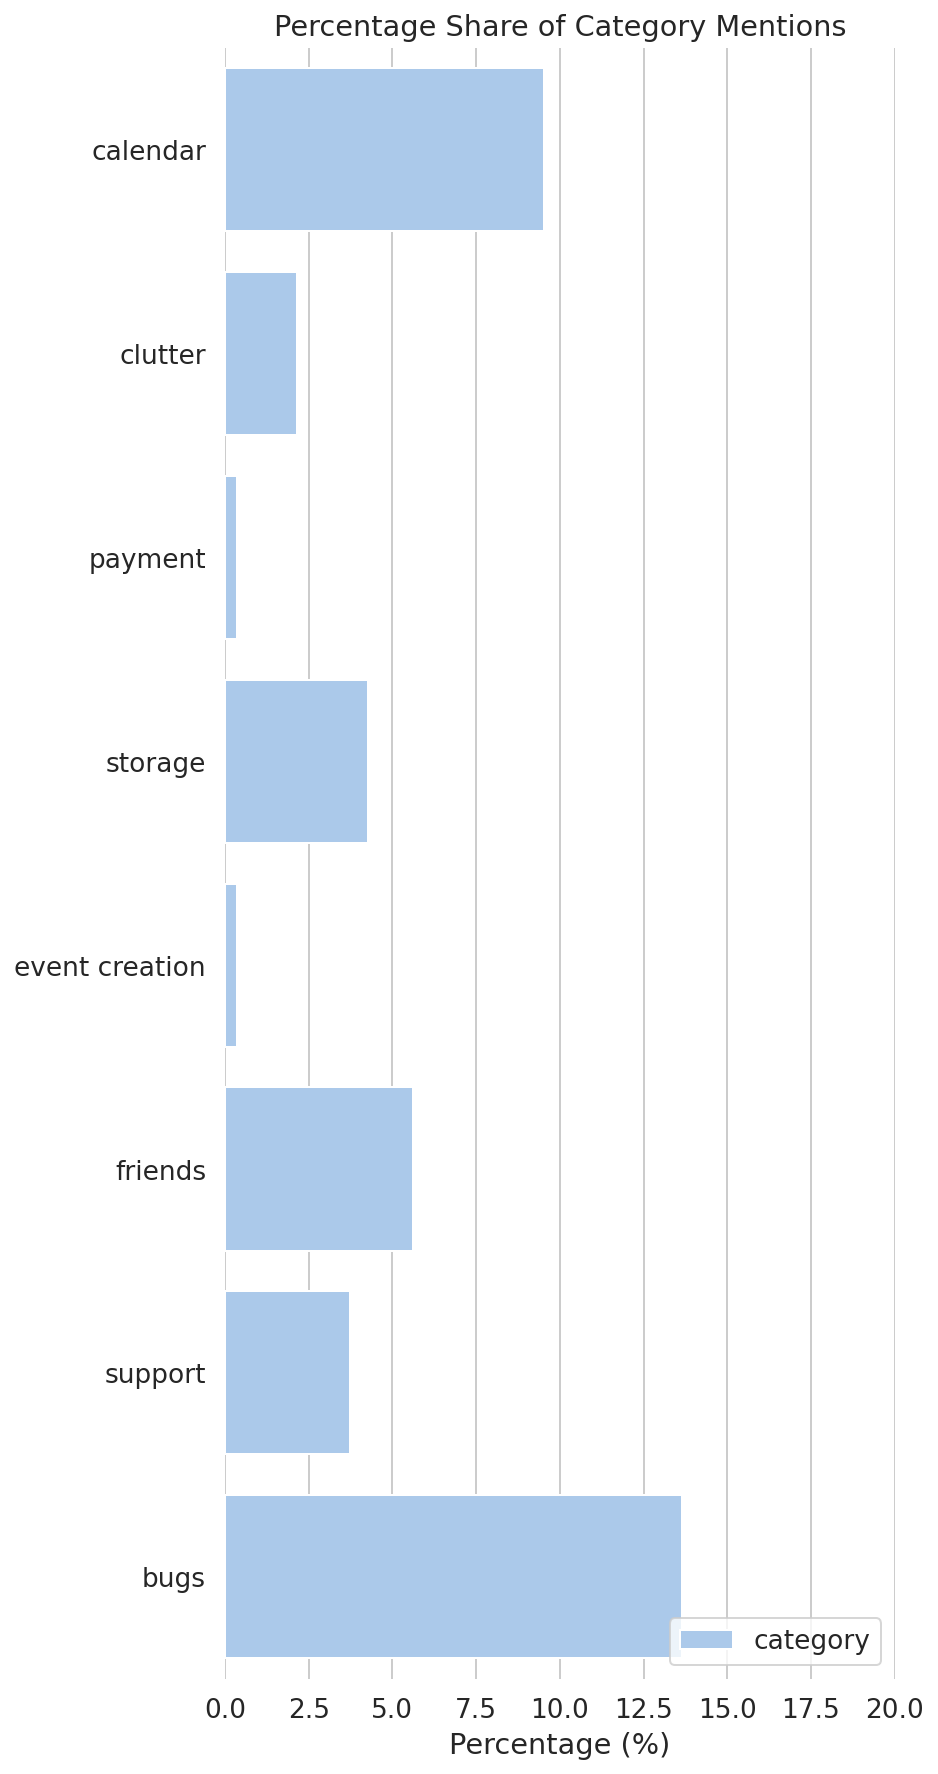

In [0]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

plt.title(label=r'Percentage Share of Category Mentions')

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(y = 'category', x = 'percentage', data=category_share_df,
            label="category", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 20), ylabel="",
       xlabel="Percentage (%)")
sns.despine(left=True, bottom=True)

In [0]:

date_temp_df = android_reviews_df
# date_temp_df.date = date_temp_df.date.apply(lambda x: int(x.split('-')[0]))

category_df = lambda q: sqldf(q, globals())
query = """
SELECT
    sum(p.calendar) as calendar_total, 
    sum(p.clutter) as clutter_total,
    sum(p.payment) as payment_total,
    sum(p.storage) as storage_total,
    sum(p.event_creation) as eventcreation_total,
    sum(p.friends) as friends_total,
    sum(p.support) as support_total,
    sum(p.bugs) as bug_total,
    p.date as date
FROM
    date_temp_df p
GROUP BY
    p.date
ORDER BY
    p.date ASC
"""
df_temp = category_df(query)
df_temp.head()
android_grouped_by_category_df = df_temp
android_grouped_by_category_df.head()

,calendar_total,clutter_total,payment_total,storage_total,eventcreation_total,friends_total,support_total,bug_total,date
0,2,0,0,0,0,2,0,0,2016-12
1,2,0,0,0,0,0,0,0,2017-03
2,0,0,0,0,0,0,0,2,2017-04
3,0,0,0,0,0,0,0,0,2017-07
4,0,0,0,0,0,0,0,2,2017-08


/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  fig.canvas.print_figure(bytes_io, **kw)


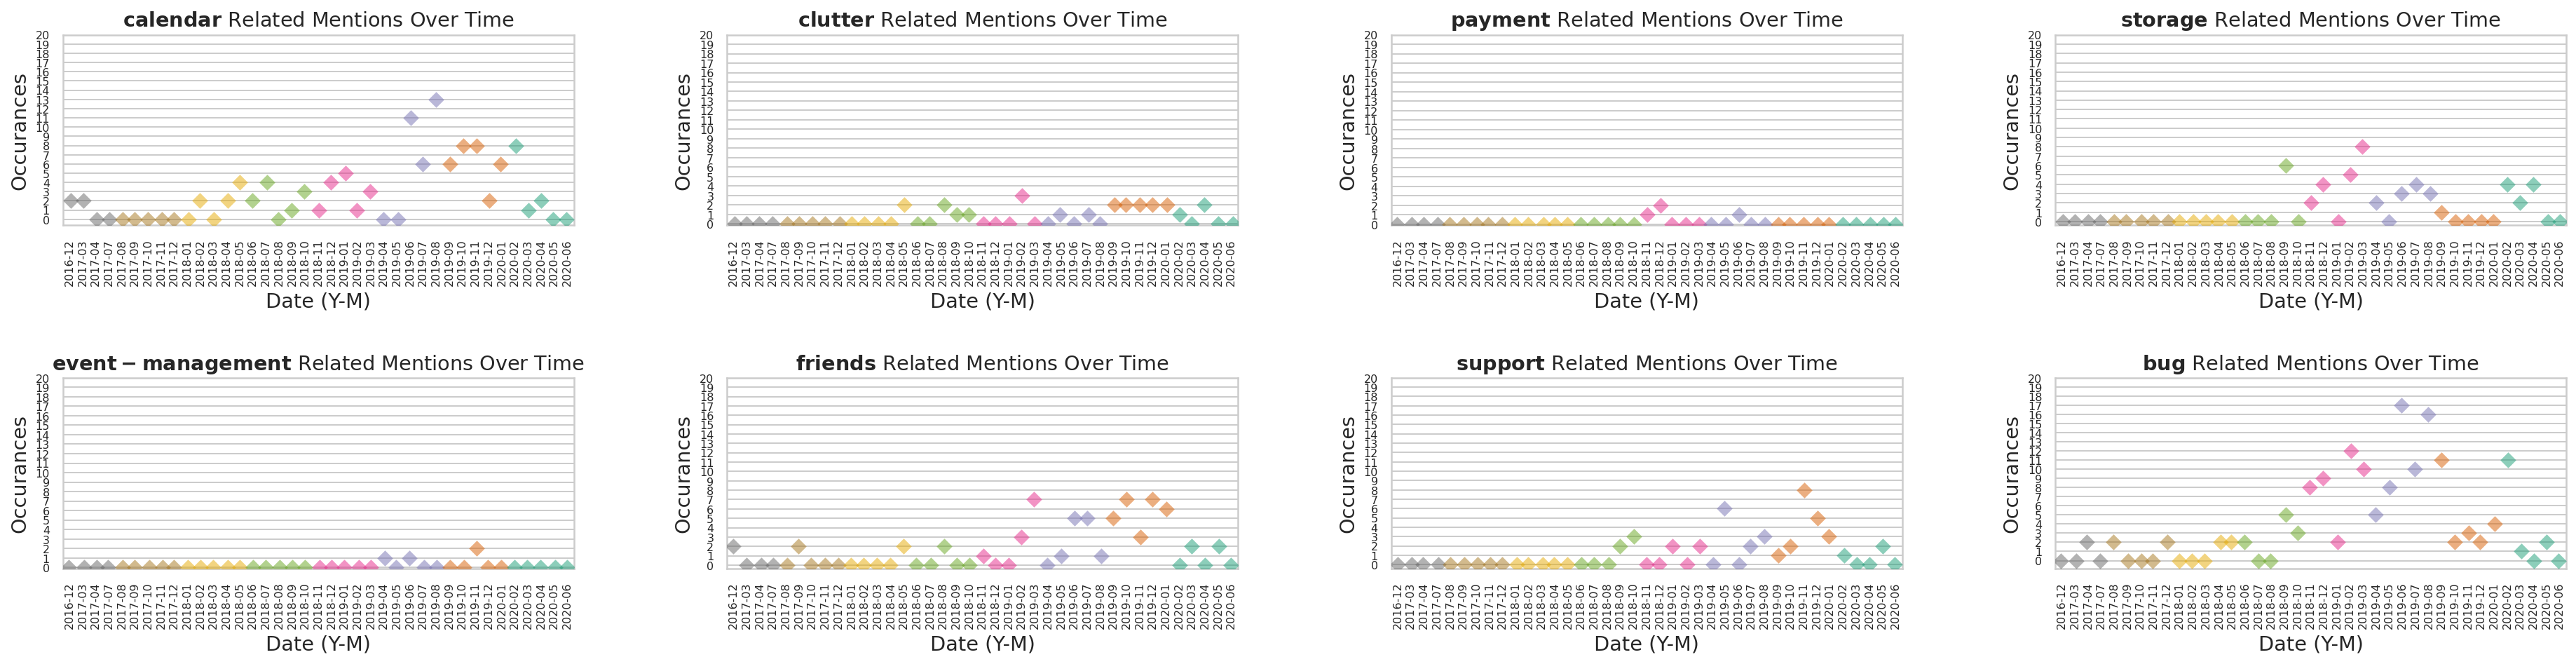

In [0]:
import matplotlib.gridspec as gridspec

grid = plt.GridSpec(2, 4, wspace=0.3, hspace=0.8)
fig = plt.figure(figsize=(32,7), constrained_layout=True)
spec = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
tick_fontSize = 8;

# fig = plt.figure(figsize=(13,6))

i = 0
j = 0
for category in category_names:
    
    try:
      plt.subplot(grid[0, i])
      category_plot = sns.stripplot(x = 'date', y= category+'_total', data = android_grouped_by_category_df, palette="Dark2_r", size=8, marker = 'D', edgecolor='gray',alpha=0.50)
      ax = plt.gca()
      my_xticks = ax.get_xticks()
      # get all the labels of this axis
      labels = ax.get_xticklabels()
      # remove the first and the last labels
      # labels[1:-1] = "                                     "
      # set these new labels
      ax.set_xticklabels(labels)
      plt.xticks(rotation=90, fontsize=tick_fontSize)    
      plt.xlabel('Date (Y-M)')
      plt.ylabel('Occurances')
      plt.yticks(ticks=range(0,21), fontsize=tick_fontSize)
      plt.title(r"$\bf{" + category + "}$" +  " Related Mentions Over Time")

      fig = category_plot.get_figure()
      i = i + 1
    except:
      plt.subplot(grid[1, j])
      if (category == 'event_creation'):
        category = 'eventcreation'
      category_plot = sns.stripplot(x = 'date', y= category+'_total', data = android_grouped_by_category_df, palette="Dark2_r", size=8, marker = 'D', edgecolor='gray',alpha=0.50)
      ax = plt.gca()
      if (category == 'eventcreation'):
        category = 'event-management'
      my_xticks = ax.get_xticks()
      # get all the labels of this axis
      labels = ax.get_xticklabels()
      # remove the first and the last labels
      # labels[1:-1] = "                                     "
      # set these new labels
      ax.set_xticklabels(labels)
      plt.xticks(rotation=90, fontsize=tick_fontSize)  
      plt.xlabel('Date (Y-M)')
      plt.ylabel('Occurances')
      plt.yticks(ticks=range(0,21), fontsize=tick_fontSize)
      plt.title(r"$\bf{" + category + "}$" +  " Related Mentions Over Time")

      fig = category_plot.get_figure()
      j = j + 1


# Summary

TBA

# References


- [Brilliant tutorial for Google Play Store Scraping](https://www.curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/)